## pix2pix pytorch lightning

### Data loader

In [1]:
%matplotlib inline
import os
import sys
from PIL import Image
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import torchvision
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

In [3]:
from models.pix2pix.datasets import ImageDataset

import albumentations as A
import torchvision.transforms as transforms

In [4]:
dataset_name = "mini_pix2pix"
img_height = 256
img_width = 256

In [5]:
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [5]:
transforms_ = [
            A.RandomResizedCrop(
                img_height,
                img_width,
            ),
            A.Rotate(13),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(),
            A.HueSaturationValue(),
            A.RGBShift(),
            A.RandomGamma(),
            # A.CLAHE(),
#             MyCoarseDropout(
#                 min_holes=1,
#                 max_holes=8,
#                 max_height=32,
#                 max_width=32,
#             ),
            # A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
            # ToTensorV2(),
        ]

In [6]:
dataset = ImageDataset("./datasets/%s" % dataset_name, transforms_=transforms_)

In [7]:
len(dataset)

20

In [8]:
def draw(A, B):    
    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(A)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(B)
    plt.title('mask')
    plt.axis('off')
    plt.show()

In [9]:
item = dataset[0]

TypeError: Invalid shape (3, 256, 256) for image data

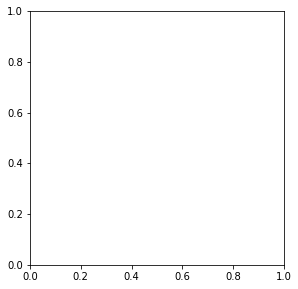

In [13]:
draw(item['A'], item['B'])

In [14]:
item['A'].shape

torch.Size([3, 256, 256])

### Train

In [1]:
from pytorch_lightning.trainer import Trainer
from models.pix2pix_model import Pix2PixModel
from torchsummary import summary
import torch

In [2]:
model = Pix2PixModel()

In [3]:
train_loader = model.train_dataloader()

In [5]:
for batch in train_loader:
    print(batch['A'].shape)
    print(batch['B'].shape)
    break

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
          UNetDown-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
          UNetDown-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
         UNetDown-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [7]:
model = Pix2PixModel(batch_size=2)

In [9]:
trainer = Trainer(gpus=[0], max_epochs=1000)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type          | Params
------------------------------------------------------
0 | generator           | GeneratorUNet | 54 M  
1 | discriminator       | Discriminator | 2 M   
2 | criterion_GAN       | MSELoss       | 0     
3 | criterion_pixelwise | L1Loss        | 0     


1